# Level Truncation in String Field Theory

H. Erbin, R. Finotello, M. Kudrna

## Minimal Models

We consider minimal models in String Field Theory and their truncation levels.
We use machine learning techniques to extrapolate the value of the truncations $L$ at $\infty$ given the results using fits of polynomials in $\frac{1}{L}$.

## Machine Learning Analysis

In what follows we proceed using a machine learning analysis on the dataset produced in the [exploratory data analysis](./minimal-models_eda.ipynb).
We consider both **support vector machines** with different kernels (linear and Gaussian) and **decision trees** (*LightGBM*).
We will use *scikit-optimize* for hyperparameter optimisation (we utilise cross-validation with 9 folds).

In [1]:
%matplotlib inline

import os
import pandas as pd
import json
import re
import joblib
import time
from datetime import datetime
from lightgbm import LGBMRegressor
from sklearn.svm import SVR, LinearSVR
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set()
ratio   = lambda x, y: (6 * y, 5 * x)

os.makedirs('./img', exist_ok=True)
os.makedirs('./models', exist_ok=True)

In [3]:
def savefig(filename, fig, show=False):
    '''
    Save a Matplotlib figure to file.
    
    Needed arguments:
        filename: the path to the saved file in the img directory (no extension),
        fig:      the Matplotlib figure object.
        
    Optional arguments:
        show: show the plot inline (bool).
    '''
    
    # save the figure to file (PDF and PNG)
    fig.tight_layout()
    fig.savefig(os.path.join('./img', filename + '.pdf'), dpi=144, format='pdf')
    fig.savefig(os.path.join('./img', filename + '.png'), dpi=144, format='png')
    
    # show if interactive
    if show:
        plt.show()
    
    # release memory
    fig.clf()
    plt.close(fig)

In [4]:
random_state = 123
np.random.seed(random_state)

## Load the Dataset

We use the pruned dataset created at the end of the [**exploratory data analysis**](./minimal-models_eda.ipynb).
We first load the JSON dataset containing the samples.
We then divide it into 90% for cross-validations and 10% test.

In [5]:
df = pd.read_json('./data/data_ml.json.gz', orient='records')

In [6]:
# take 80% for training
df_train = df.sample(frac=0.9, random_state=random_state)
df_test  = df.loc[~df.index.isin(df_train.index)].copy()

n_train = df_train.shape[0]
n_test = df_test.shape[0]

# check that the shapes are ok
assert n_train + n_test == df.shape[0]

In [7]:
# save the input shape for later use (NB: -1 for the labels, -2 for solution and observable columns)
features_shape = (df_train.shape[1] - 1 - 2,)

In [8]:
# number of iterations of the hyperparameter optimisation
n_iter = 50

# number of cross-validation folds
cv = 9

# save the model into the appropriate directory
now     = datetime.now().strftime("%d%m%Y_%H%M%S")
now_dir = 'ml_' + now
now_dir = os.path.join('./models', now_dir)
print(f'Current working directory: {now_dir}')

os.makedirs(now_dir)

Current working directory: ./models/ml_25112020_141749


## Normalisation of the Features

We scale the features to the interval $[0,\, 1]$ to improve scalability of the deep learning technique:

In [9]:
norm_cols    = [c for c in df_train.columns if re.match('^lev_', c)]
min_max_cols = [(c, np.min(df_train[c]), np.max(df_train[c])) for c in norm_cols]

# apply the transformation
for c, m, M in min_max_cols:
    df_train[c] = df_train[c].apply(lambda x: (x - m) / (M - m))
    df_test[c]  = df_test[c].apply(lambda x: (x - m) / (M - m))

In [10]:
X_train = df_train.drop(columns=['solution', 'observable', 'exp'])
X_test  = df_test.drop(columns=['solution', 'observable', 'exp'])

y_train = df_train['exp']
y_test  = df_test['exp']

The following functions are helper methods to pretty print and analyse the results.

In [11]:
def print_best_params(estimator):
    '''
    Print the best parameters.
    
    Needed arguments:
        estimator: the fitted BayesSearchCV estimator.
        
    Returns:
        best CV parameters.
    '''
    
    est_name    = estimator.estimator.__class__.__name__
    best_params = estimator.best_params_
    
    return pd.DataFrame(best_params, index=[est_name])

In [12]:
def cv_results(estimator):
    '''
    Extract CV results.
    
    Needed arguments:
        estimator: the fitted BayesSearchCV estimator.
        
    Returns:
        metrics, predictions, residuals
    '''
    
    # extract the best estimator
    est        = estimator.best_estimator_
    est_name   = estimator.estimator.__class__.__name__.lower()
    best_index = estimator.best_index_
    cv_results = estimator.cv_results_
    
    # save model to file
    joblib.dump(est, os.path.join(now_dir, est_name + '.joblib'))
    
    # compute the predictions
    predictions = {'training':      list(est.predict(X_train)),
                   'training_true': list(y_train),
                   'test':          list(est.predict(X_test)),
                   'test_true':     list(y_test)
                  }
    
    # compute residuals
    residuals  = {'training': list(predictions['training'] - y_train),
                  'test':     list(predictions['test'] - y_test)
                 }
    
    # compute metrics
    metrics = {'train_mse':     np.mean(np.square(predictions['training'] - y_train)),
               'train_mae':     np.mean(np.abs(predictions['training'] - y_train)),
               'train_cv_mean': np.abs(cv_results['mean_test_score'][best_index]),
               'train_cv_std':  cv_results['std_test_score'][best_index],
               'test_mse':      np.mean(np.square(predictions['test'] - y_test)),
               'test_mae':      np.mean(np.abs(predictions['test'] - y_test))
              }
    metrics = pd.DataFrame(metrics, index=[est_name])
    
    return metrics, predictions, residuals

In [13]:
def fit_time(estimator):
    '''
    Fit the estimator and display training time.
    
    Needed arguments:
        estimator: the estimator to fit.
    '''
    
    # fit keeping track of the time
    start = time.time()
    start_str = time.strftime('%H:%M:%S.', time.gmtime(start))
    print(f'Start: {start_str}')
    
    estimator = estimator.fit(X_train, y_train)
    
    stop = time.time()
    stop_str = time.strftime('%H:%M:%S.', time.gmtime(stop))
    print(f'Stop: {stop_str}')
    
    diff = stop - start
    diff_str = time.strftime('Training ended in %H hours, %M minutes and %S seconds.', time.gmtime(diff))
    print(diff_str)
    
    return estimator

## Decision Trees

We now consider the impact of boosted decision trees on the determination of the result.

In [14]:
search = {'num_leaves':        Integer(10, 100),
          'max_depth':         Integer(2, 100),
          'learning_rate':     Real(1.0e-4, 1.0e-1, prior='log-uniform'),
          'n_estimators':      Integer(1e2, 1e4, prior='log-uniform'),
          'min_child_samples': Integer(10, 50),
          'colsample_bytree':  Real(0.5, 1.0),
          'reg_alpha':         Real(1.0e-6, 1.0e-1, prior='log-uniform'),
          'reg_lambda':        Real(1.0e-6, 1.0e-1, prior='log-uniform')
         }

gbdt = BayesSearchCV(LGBMRegressor(random_state=random_state, n_jobs=1),
                     search,
                     scoring='neg_mean_squared_error',
                     n_iter=n_iter,
                     cv=cv,
                     n_jobs=-1,
                     random_state=random_state
                    )
gbdt = fit_time(gbdt)

Start: 13:17:49.
Stop: 13:21:49.
Training ended in 00 hours, 04 minutes and 00 seconds.


In [15]:
# print the best parameters
print_best_params(gbdt)

,colsample_bytree,learning_rate,max_depth,min_child_samples,n_estimators,num_leaves,reg_alpha,reg_lambda
LGBMRegressor,0.5,0.001572,100,10,8598,100,0.1,0.1


In [16]:
# extract predictions and metrics
metrics, predictions, residuals = cv_results(gbdt)
with open('./data/gbdt_predictions.json', 'w') as f:
    json.dump(predictions, f)
metrics

,train_mse,train_mae,train_cv_mean,train_cv_std,test_mse,test_mae
lgbmregressor,0.013479,0.031155,0.061584,0.022037,0.112979,0.142882


We then plot the histogram of the residuals and the residual plot on the cross-validation and test sets:

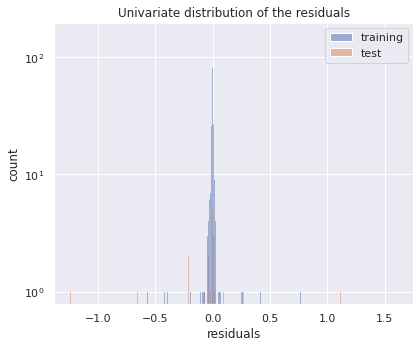

In [17]:
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))

sns.histplot(data=residuals,
             stat='count',
             log_scale=[False, True],
             alpha=0.5,
             ax=ax
            )
ax.set(title='Univariate distribution of the residuals',
       xlabel='residuals',
       ylabel='count'
      )

savefig('gbdt_histogram', fig, show=True)

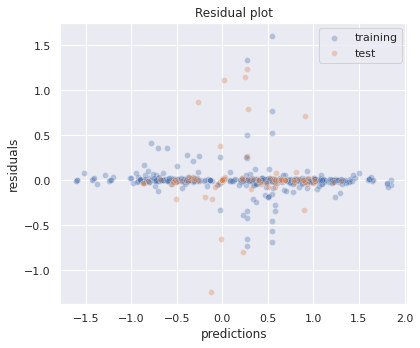

In [18]:
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))

sns.scatterplot(x=predictions['training'],
                y=residuals['training'],
                alpha=0.35,
                ax=ax
               )
sns.scatterplot(x=predictions['test'],
                y=residuals['test'],
                alpha=0.35,
                ax=ax
               )
ax.set(title='Residual plot',
       xlabel='predictions',
       ylabel='residuals'
      )
ax.legend(['training', 'test'])

savefig('gbdt_resplot', fig, show=True)

## Linear SVR

We then consider several *support vector machine* algorithms starting from the linear case.

In [19]:
search = {'epsilon':           Real(0.0, 10.0), 
          'C':                 Real(1.0e-1, 1.0e3, prior='log-uniform'),
          'loss':              Categorical(['epsilon_insensitive', 'squared_epsilon_insensitive']),
          'fit_intercept':     Integer(0, 1),
          'intercept_scaling': Real(1.0e-2, 1.0e2, prior='log-uniform')
         }

lsvr = BayesSearchCV(LinearSVR(random_state=random_state, max_iter=1000),
                     search,
                     scoring='neg_mean_squared_error',
                     n_iter=n_iter,
                     cv=cv,
                     n_jobs=-1,
                     random_state=random_state
                    )
lsvr = fit_time(lsvr)

Start: 13:21:57.
Stop: 13:22:49.
Training ended in 00 hours, 00 minutes and 51 seconds.


/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [20]:
# print the best parameters
print_best_params(lsvr)

,C,epsilon,fit_intercept,intercept_scaling,loss
LinearSVR,29.734963,0.0,0,0.01,squared_epsilon_insensitive


In [21]:
# extract predictions and metrics
metrics, predictions, residuals = cv_results(lsvr)
with open('./data/lsvr_predictions.json', 'w') as f:
    json.dump(predictions, f)
    
metrics

,train_mse,train_mae,train_cv_mean,train_cv_std,test_mse,test_mae
linearsvr,0.188778,0.301348,0.216536,0.056832,0.204791,0.303229


We then plot the histogram of the residuals and the residual plot on the cross-validation and test sets:

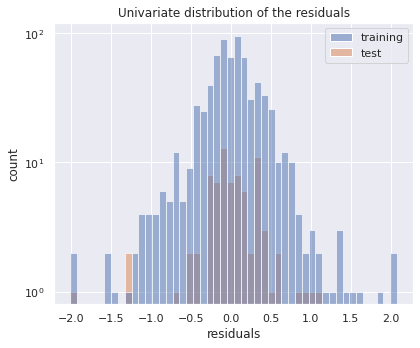

In [22]:
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))

sns.histplot(data=residuals,
             stat='count',
             log_scale=[False, True],
             alpha=0.5,
             ax=ax
            )
ax.set(title='Univariate distribution of the residuals',
       xlabel='residuals',
       ylabel='count'
      )

savefig('lsvr_histogram', fig, show=True)

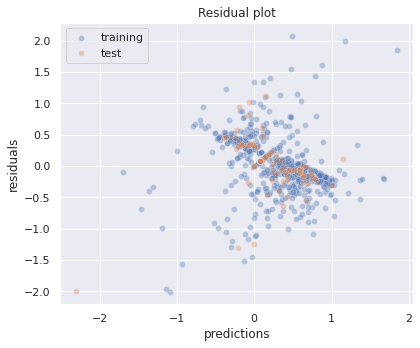

In [23]:
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))

sns.scatterplot(x=predictions['training'],
                y=residuals['training'],
                alpha=0.35,
                ax=ax
               )
sns.scatterplot(x=predictions['test'],
                y=residuals['test'],
                alpha=0.35,
                ax=ax
               )
ax.set(title='Residual plot',
       xlabel='predictions',
       ylabel='residuals'
      )
ax.legend(['training', 'test'])

savefig('lsvr_resplot', fig, show=True)

## Gaussian SVR

We consider the case of a Gaussian *kernel trick*.

In [24]:
search = {'gamma':   Categorical(['scale', 'auto']),
          'C':       Real(1.0e-2, 1.0e3, prior='log-uniform'),
          'epsilon': Real(1.0e-3, 1.0e1, prior='log-uniform')
         }

rsvr = BayesSearchCV(SVR(kernel='rbf'),
                     search,
                     scoring='neg_mean_squared_error',
                     n_iter=n_iter,
                     cv=cv,
                     n_jobs=-1,
                     random_state=random_state
                    )
rsvr = fit_time(rsvr)

Start: 13:22:50.


/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Stop: 13:23:42.
Training ended in 00 hours, 00 minutes and 52 seconds.


In [25]:
# print the best parameters
print_best_params(rsvr)

,C,epsilon,gamma
SVR,1000.0,0.005642,scale


In [26]:
# extract predictions and metrics
metrics, predictions, residuals = cv_results(rsvr)
with open('./data/lsvr_predictions.json', 'w') as f:
    json.dump(predictions, f)
    
metrics

,train_mse,train_mae,train_cv_mean,train_cv_std,test_mse,test_mae
svr,0.010577,0.035865,0.072578,0.047716,0.076928,0.098945


We then plot the histogram of the residuals and the residual plot on the cross-validation and test sets:

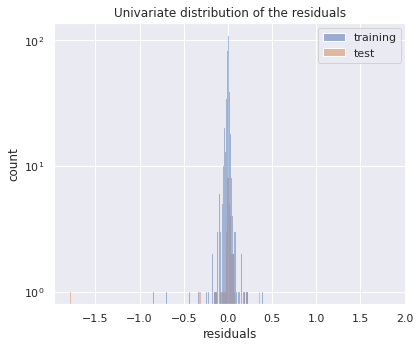

In [27]:
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))

sns.histplot(data=residuals,
             stat='count',
             log_scale=[False, True],
             alpha=0.5,
             ax=ax
            )
ax.set(title='Univariate distribution of the residuals',
       xlabel='residuals',
       ylabel='count'
      )

savefig('rsvr_histogram', fig, show=True)

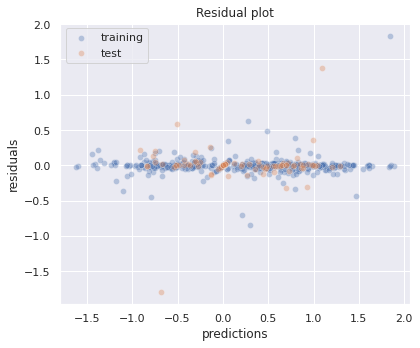

In [28]:
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))

sns.scatterplot(x=predictions['training'],
                y=residuals['training'],
                alpha=0.35,
                ax=ax
               )
sns.scatterplot(x=predictions['test'],
                y=residuals['test'],
                alpha=0.35,
                ax=ax
               )
ax.set(title='Residual plot',
       xlabel='predictions',
       ylabel='residuals'
      )
ax.legend(['training', 'test'])

savefig('rsvr_resplot', fig, show=True)

## Polynomial SVR

We finally consider the case of a polynomial kernel.

In [36]:
search = {'degree':  Integer(2, 3),
          'gamma':   Categorical(['scale', 'auto']),
          'coef0':   Real(-1.0, 1.0),
          'C':       Real(1.0e-2, 1.0e3, prior='log-uniform'),
          'epsilon': Real(1.0e-3, 1.0e1, prior='log-uniform')
         }

psvr = BayesSearchCV(SVR(kernel='poly'),
                     search,
                     scoring='neg_mean_squared_error',
                     n_iter=int(n_iter/10),
                     cv=cv,
                     n_jobs=-1,
                     random_state=random_state
                    )
psvr = fit_time(psvr)

Start: 20:41:39.
Stop: 20:41:44.
Training ended in 00 hours, 00 minutes and 05 seconds.


In [37]:
# print the best parameters
print_best_params(psvr)

,C,coef0,degree,epsilon,gamma
SVR,6.502414,-0.291791,2,0.35766,scale


In [38]:
# extract predictions and metrics
metrics, predictions, residuals = cv_results(psvr)
with open('./data/lsvr_predictions.json', 'w') as f:
    json.dump(predictions, f)
    
metrics

,train_mse,train_mae,train_cv_mean,train_cv_std,test_mse,test_mae
svr,0.076212,0.18912,0.167632,0.110751,0.108749,0.206155


We then plot the histogram of the residuals and the residual plot on the cross-validation and test sets:

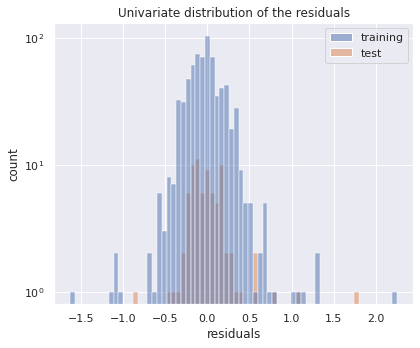

In [39]:
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))

sns.histplot(data=residuals,
             stat='count',
             log_scale=[False, True],
             alpha=0.5,
             ax=ax
            )
ax.set(title='Univariate distribution of the residuals',
       xlabel='residuals',
       ylabel='count'
      )

savefig('psvr_histogram', fig, show=True)

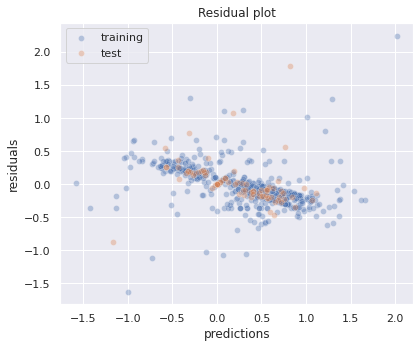

In [40]:
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))

sns.scatterplot(x=predictions['training'],
                y=residuals['training'],
                alpha=0.35,
                ax=ax
               )
sns.scatterplot(x=predictions['test'],
                y=residuals['test'],
                alpha=0.35,
                ax=ax
               )
ax.set(title='Residual plot',
       xlabel='predictions',
       ylabel='residuals'
      )
ax.legend(['training', 'test'])

savefig('psvr_resplot', fig, show=True)